# 2.155/6 Challenge Problem 2
<div style="font-size: small;">
License Terms:  
These Python demos are licensed under a <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 International License</a>. They are intended for educational use only in Class 2.155/2.156: AI and ML for Engineering Design at MIT. You may not share or distribute them publicly, use them for commercial purposes, or provide them to industry or other entities without permission from the instructor (faez@mit.edu).
</div>

<font size="1">
  Pixel Art by J. Shung. </font>

# TODO
- Design new grids using GAs and rules of observations how advisors work
- Improve feature engineering
- Select better grids for diversity (not just off top minimum scores)

In [1]:
from utils_public import *
import numpy as np
import pandas as pd
import os, time
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.base import clone

from autogluon.tabular import TabularPredictor

# This was needed to prevent several of the models from locking up when loading from autogluon saves
os.environ.update({"OMP_NUM_THREADS":"1","MKL_NUM_THREADS":"1","OPENBLAS_NUM_THREADS":"1"})

## Creating Grids

In [2]:
original_grids = load_grids()
grids = original_grids # may overwrite this later
ratings = np.load("datasets/scores.npy")
ratings_df = pd.DataFrame(ratings, columns = ["Wellness", "Tax", "Transportation", "Business"])

In [3]:
# TODO generate new grids with genetic algorithms?

## Training Advisor Models

In [8]:
## FEATURE ENGINEERING ##

from scipy import ndimage

def interface_count(grid, a, b):
    # 4-neighbor interfaces between labels a and b
    g = grid
    right = (g[:, :-1] == a) & (g[:, 1:] == b)
    right |= (g[:, :-1] == b) & (g[:, 1:] == a)
    down = (g[:-1, :] == a) & (g[1:, :] == b)
    down |= (g[:-1, :] == b) & (g[1:, :] == a)
    return right.sum() + down.sum()

def connectivity_features(grid, label):
    mask = (grid == label).astype(np.uint8)
    if mask.sum() == 0:
        return 0, 0, 0.0
    struct = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=np.uint8)  # 4-neighborhood
    comp, n = ndimage.label(mask, structure=struct)
    sizes = np.bincount(comp.ravel())[1:]
    return n, sizes.max(), sizes.mean()

def symmetry_scores(grid):
    h = 1.0 - (np.mean(grid == np.fliplr(grid)))
    v = 1.0 - (np.mean(grid == np.flipud(grid)))
    return h, v

def cooccurrence_4n(grid, n_labels=5):
    # counts of adjacent pairs (unordered) across 4-neighbors
    counts = np.zeros((n_labels, n_labels), dtype=np.int32)
    # right neighbors
    a, b = grid[:, :-1], grid[:, 1:]
    for i in range(n_labels):
        for j in range(i, n_labels):
            c = ((a == i) & (b == j)) | ((a == j) & (b == i))
            counts[i, j] += c.sum()
            if i != j:
                counts[j, i] = counts[i, j]
    # down neighbors
    a, b = grid[:-1, :], grid[1:, :]
    for i in range(n_labels):
        for j in range(i, n_labels):
            c = ((a == i) & (b == j)) | ((a == j) & (b == i))
            counts[i, j] += c.sum()
            if i != j:
                counts[j, i] = counts[i, j]
    return counts

def feature_eng_adv(grids):
    # grids: (N, 7, 7) int
    N = grids.shape[0]
    feats = []
    for g in grids:
        counts = [(g == k).sum() for k in range(5)]
        props = [c / 49.0 for c in counts]

        # interfaces
        iface = {(i, j): interface_count(g, i, j) for i in range(5) for j in range(i+1, 5)}
        total_iface = sum(iface.values())

        # connectivity
        n0, max0, mean0 = connectivity_features(g, 0)
        n1, max1, mean1 = connectivity_features(g, 1)
        n2, max2, mean2 = connectivity_features(g, 2)
        n3, max3, mean3 = connectivity_features(g, 3)
        n4, max4, mean4 = connectivity_features(g, 4)
        ns = [n0, n1, n2, n3, n4]
        maxs = [max0, max1, max2, max3, max4]
        means = [mean0, mean1, mean2, mean3, mean4]

        # symmetry
        sym_h, sym_v = symmetry_scores(g)

        # center vs border for label 0
        center_mask = np.zeros_like(g, dtype=bool)
        center_mask[2:5, 2:5] = True
        # Center vs border for all labels (0 through 4)
        center_counts = [(g[center_mask] == k).sum() for k in range(5)]
        border_counts = [(g[~center_mask] == k).sum() for k in range(5)]

        # interactions
        prop_pairs = [props[i]*props[j] for i in range(5) for j in range(i+1, 5)]
        sdiv = lambda a,b: a / (b + 1e-6)
        largest_ratios = [sdiv(maxs[k], counts[k]) for k in range(5)]

        frags = [sdiv(ns[k], counts[k]) for k in range(5)]
        center_ratios = [sdiv(center_counts[k], center_counts[k] + border_counts[k]) for k in range(5)]
        iface_density = sdiv(total_iface, 84.0)  # total 4-neighbor edges in 7x7
        iface_03_norm = sdiv(iface[(0,3)], counts[0] + counts[3])
        # Symmetry-proportion interactions for all labels (0 through 4)
        sym_h_props = [sym_h * props[k] for k in range(5)]
        sym_v_props = [sym_v * props[k] for k in range(5)]

        # Build feature vector
        feat_vec = [
            *counts, *props,
            total_iface, iface[(0,3)], iface[(0,4)], iface[(1,3)], iface[(2,4)], 
            n0, max0, mean0,
            n1, max1, mean1,
            n2, max2, mean2,
            n3, max3, mean3,
            n4, max4, mean4,
            sym_h, sym_v,
            *center_counts, *border_counts,
            *prop_pairs,
            *largest_ratios, *frags, *center_ratios,
            iface_density, iface_03_norm,
            *sym_h_props, *sym_v_props
        ]
        feats.append(feat_vec)

    features = np.asarray(feats, dtype=np.float32)
    grids_flat = grids.reshape(-1, 49) # flatten the grids
    grids_out = np.hstack([grids_flat, features]) #stack the features horizontally with the flattened grids
    return grids_out.astype(np.float32)
    

def append_district_counts(grids): #performs the feature engineering to add district counts
    grids_flat = grids.reshape(-1, 49) #first flatten the grids

    counts = [np.sum(grids_flat==0, axis=1),
              np.sum(grids_flat==1, axis=1),
              np.sum(grids_flat==2, axis=1),
              np.sum(grids_flat==3, axis=1),
              np.sum(grids_flat==4, axis=1)] #list of 5 length n_grids arrays containing counts of each district
    features = np.stack(counts).T #stack and transpose counts to get n_grids x 5 array
    grids_out = np.hstack([grids_flat, features]) #stack the features horizontally with the flattened grids
    return grids_out.astype(np.float32)

# JC's feature engineering for advisor 2
def append_district_distances(grids):
    """
    Calculate pairwise distances between different district types for each grid.
    Uses Manhattan distance between cells.

    Parameters:
    grids (numpy.ndarray): Array of shape (n_samples, 7, 7) containing district layouts

    Returns:
    numpy.ndarray: Original features concatenated with district distance features
    """
    n_samples = grids.shape[0]
    n_districts = 5
    district_distances = np.zeros((n_samples, n_districts * n_districts))

    # Create coordinate matrices
    y_coords, x_coords = np.meshgrid(range(7), range(7))

    for idx, grid in enumerate(grids):
        dist_idx = 0
        # Calculate distances from each district type to each district type
        for dist1 in range(n_districts):
            # Get coordinates of all cells containing district type dist1
            cells1 = np.where(grid == dist1)
            if len(cells1[0]) == 0:  # Skip if no cells of this type
                dist_idx += n_districts
                continue

            for dist2 in range(n_districts):
                cells2 = np.where(grid == dist2)
                if len(cells2[0]) == 0:  # Skip if no cells of this type
                    dist_idx += 1
                    continue

                # Calculate Manhattan distances between all pairs
                total_dist = 0
                for x1, y1 in zip(cells1[0], cells1[1]):
                    for x2, y2 in zip(cells2[0], cells2[1]):
                        total_dist += abs(x2 - x1) + abs(y2 - y1)

                # Normalize by number of pairs to get average distance
                n_pairs = len(cells1[0]) * len(cells2[0])
                district_distances[idx, dist_idx] = total_dist / n_pairs
                dist_idx += 1

    # Get the original features
    grids_flat = grids.reshape(n_samples, -1)
    counts = np.array([np.sum(grids == i, axis=(1,2)) for i in range(n_districts)]).T

    # Combine all features
    return np.hstack([grids_flat, counts, district_distances])

## FITTING REGRESSORS ##
    
def advisor_train(grids, ratings, advisor):
    FE_fn = FE_fns[advisor]
    grids_train, ratings_train = select_rated_subset(grids, ratings[:,advisor]) #gets subset of the dataset rated by advisor
    grids_fa = pd.DataFrame(FE_fn(grids_train)).astype(np.float32)

    all_train = grids_fa.copy().astype(np.float32)
    all_train["label"] = ratings_train

    predictor = TabularPredictor(label='label',
                                 problem_type='regression',
                                 verbosity=4,
                                 eval_metric='r2')
    predictor.fit(all_train, presets='medium', time_limit=60)
    predictor.delete_models(models_to_keep='best')

    # Compute and display permutation feature importance on training data (NOT WORKING)
    # fi = predictor.feature_importance(all_train, subsample_size=2000, time_limit=30)
    # fi_top = fi.sort_values('importance', ascending=False).head(25)
    # print("Top feature importances:")
    # print(fi_top[['importance', 'stddev', 'p_value']])
    # fi.to_csv(predictor.path + f"/feature_importance_advisor{advisor}.csv")

    return predictor

models = ["ag-20251023_181354",
          "ag-20251021_231536",
          "ag-20251024_212450",
          "ag-20251021_231705",]

#TODO more feature engineering for advisor 0 and 2
FE_fns = [feature_eng_adv,
          append_district_counts,
          append_district_distances,
          append_district_counts]

for advisor in [2]:
    # Use this for training new models
    advisor_train(grids, ratings, advisor)

No path specified. Models will be saved in: "AutogluonModels/ag-20251024_212753"
Preset alias specified: 'medium' maps to 'medium_quality'.
Verbosity: 4 (Maximum Logging)
loky.cpu_count(only_physical_cores=False): 12
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.0
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 25.0.0: Wed Sep 17 21:41:50 PDT 2025; root:xnu-12377.1.9~141/RELEASE_ARM64_T6030
CPU Count:          12
GPU Count:          1
Memory Avail:       17.46 GB / 36.00 GB (48.5%)
Disk Space Avail:   222.59 GB / 460.43 GB (48.3%)
Presets specified: ['medium']
============ fit kwarg info ============
User Specified kwargs:
{'auto_stack': False}
Full kwargs:
{'_experimental_dynamic_hyperparameters': False,
 '_feature_generator_kwargs': None,
 '_save_bag_folds': None,
 'ag_args': None,
 'ag_args_ensemble': None,
 'ag_args_fit': None,
 'auto_stack': False,
 'calibrate': 'auto',
 'delay_

[1]	valid_set's l2: 0.0767202	valid_set's r2: 0.024629
[2]	valid_set's l2: 0.07473	valid_set's r2: 0.049931
[3]	valid_set's l2: 0.0728742	valid_set's r2: 0.0735238
[4]	valid_set's l2: 0.0715818	valid_set's r2: 0.0899544
[5]	valid_set's l2: 0.0703722	valid_set's r2: 0.105333
[6]	valid_set's l2: 0.0690519	valid_set's r2: 0.122118
[7]	valid_set's l2: 0.0673833	valid_set's r2: 0.143332
[8]	valid_set's l2: 0.065787	valid_set's r2: 0.163626
[9]	valid_set's l2: 0.0648513	valid_set's r2: 0.175522
[10]	valid_set's l2: 0.0636167	valid_set's r2: 0.191218
[11]	valid_set's l2: 0.0626934	valid_set's r2: 0.202956
[12]	valid_set's l2: 0.0618877	valid_set's r2: 0.213199
[13]	valid_set's l2: 0.0609016	valid_set's r2: 0.225736
[14]	valid_set's l2: 0.0598245	valid_set's r2: 0.239429
[15]	valid_set's l2: 0.0586657	valid_set's r2: 0.254162
[16]	valid_set's l2: 0.0576985	valid_set's r2: 0.266458
[17]	valid_set's l2: 0.0570059	valid_set's r2: 0.275264
[18]	valid_set's l2: 0.0560906	valid_set's r2: 0.2869
[19]

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBMXT/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/LightGBMXT/y_pred_proba_val.pkl
	0.5869	 = Validation score   (r2)
	2.98s	 = Training   runtime
	0.0s	 = Validation runtime
	201378.1	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Fitting model: LightGBM ... Training model for up to 56.22s of the 56.21s of remaining time.
loky.cpu_count(only_physical_cores=False): 12
loky.cpu_count(only_physical_cores=True): 12
	Fitting LightGBM with 'num_gpus': 0, 'num_cpus': 12
	Fitting with cpus=12, gpus=0, mem=0.0/17.5 GB
	Fitting 10000 rounds... Hyperparameters: {'learning_rate': 0.05}


[720]	valid_set's l2: 0.0329451	valid_set's r2: 0.581157
[721]	valid_set's l2: 0.0329516	valid_set's r2: 0.581074
[722]	valid_set's l2: 0.0329541	valid_set's r2: 0.581042
[723]	valid_set's l2: 0.0329534	valid_set's r2: 0.581051
[1]	valid_set's l2: 0.075043	valid_set's r2: 0.0459514
[2]	valid_set's l2: 0.0719438	valid_set's r2: 0.0853528
[3]	valid_set's l2: 0.0690156	valid_set's r2: 0.122579
[4]	valid_set's l2: 0.0666287	valid_set's r2: 0.152925
[5]	valid_set's l2: 0.0644152	valid_set's r2: 0.181067
[6]	valid_set's l2: 0.0621986	valid_set's r2: 0.209247
[7]	valid_set's l2: 0.0603722	valid_set's r2: 0.232467
[8]	valid_set's l2: 0.0585094	valid_set's r2: 0.256149
[9]	valid_set's l2: 0.0568249	valid_set's r2: 0.277565
[10]	valid_set's l2: 0.0554332	valid_set's r2: 0.295258
[11]	valid_set's l2: 0.0541662	valid_set's r2: 0.311366
[12]	valid_set's l2: 0.0529139	valid_set's r2: 0.327287
[13]	valid_set's l2: 0.0517938	valid_set's r2: 0.341526
[14]	valid_set's l2: 0.0508095	valid_set's r2: 0.354

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBM/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/LightGBM/y_pred_proba_val.pkl
	0.6063	 = Validation score   (r2)
	2.11s	 = Training   runtime
	0.0s	 = Validation runtime
	410884.0	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Fitting model: RandomForestMSE ... Training model for up to 54.11s of the 54.10s of remaining time.
loky.cpu_count(only_physical_cores=False): 12
loky.cpu_count(only_physical_cores=False): 12
	Fitting RandomForestMSE with 'num_gpus': 0, 'num_cpus': 12
	Fitting with cpus=12, gpus=0


[475]	valid_set's l2: 0.0314309	valid_set's r2: 0.600408
[476]	valid_set's l2: 0.0314178	valid_set's r2: 0.600574
[477]	valid_set's l2: 0.0314073	valid_set's r2: 0.600708
[478]	valid_set's l2: 0.0313981	valid_set's r2: 0.600825
[479]	valid_set's l2: 0.0314221	valid_set's r2: 0.60052
[480]	valid_set's l2: 0.031425	valid_set's r2: 0.600482
[481]	valid_set's l2: 0.0314294	valid_set's r2: 0.600426
[482]	valid_set's l2: 0.0314205	valid_set's r2: 0.60054
[483]	valid_set's l2: 0.0314121	valid_set's r2: 0.600646
[484]	valid_set's l2: 0.0314183	valid_set's r2: 0.600568
[485]	valid_set's l2: 0.0314173	valid_set's r2: 0.60058
[486]	valid_set's l2: 0.0314171	valid_set's r2: 0.600583
[487]	valid_set's l2: 0.0314156	valid_set's r2: 0.600602
[488]	valid_set's l2: 0.0314168	valid_set's r2: 0.600586
[489]	valid_set's l2: 0.031418	valid_set's r2: 0.600572
[490]	valid_set's l2: 0.0314233	valid_set's r2: 0.600505
[491]	valid_set's l2: 0.0314213	valid_set's r2: 0.60053
[492]	valid_set's l2: 0.0314229	valid

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/RandomForestMSE/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/RandomForestMSE/y_pred_proba_val.pkl
	0.5447	 = Validation score   (r2)
	2.48s	 = Training   runtime
	0.03s	 = Validation runtime
	18692.2	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Fitting model: CatBoost ... Training model for up to 51.54s of the 51.53s of remaining time.
loky.cpu_count(only_physical_cores=False): 12
loky.cpu_count(only_physical_cores=True): 12
	Fitting CatBoost with 'num_gpus': 0, 'num_cpus': 12
	Fitting with cpus=12, gpus=0
	Catboost model hyperparameters: {'iterations': 10000, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'R2', 'thread_count': 12, 'loss_function': 'RMSE

0:	learn: 0.0315290	test: 0.0273021	best: 0.0273021 (0)	total: 1.18ms	remaining: 11.8s
1:	learn: 0.0567171	test: 0.0490291	best: 0.0490291 (1)	total: 2.36ms	remaining: 11.8s
2:	learn: 0.0819015	test: 0.0705886	best: 0.0705886 (2)	total: 3.36ms	remaining: 11.2s
3:	learn: 0.1052966	test: 0.0914430	best: 0.0914430 (3)	total: 4.72ms	remaining: 11.8s
4:	learn: 0.1251718	test: 0.1087014	best: 0.1087014 (4)	total: 5.8ms	remaining: 11.6s
5:	learn: 0.1471933	test: 0.1309802	best: 0.1309802 (5)	total: 6.74ms	remaining: 11.2s
6:	learn: 0.1671496	test: 0.1487314	best: 0.1487314 (6)	total: 7.67ms	remaining: 11s
7:	learn: 0.1856771	test: 0.1653876	best: 0.1653876 (7)	total: 8.6ms	remaining: 10.7s
8:	learn: 0.2066757	test: 0.1856715	best: 0.1856715 (8)	total: 9.55ms	remaining: 10.6s
9:	learn: 0.2231474	test: 0.1988064	best: 0.1988064 (9)	total: 10.5ms	remaining: 10.5s
10:	learn: 0.2377785	test: 0.2119584	best: 0.2119584 (10)	total: 11.6ms	remaining: 10.5s
11:	learn: 0.2538817	test: 0.2260133	best: 0.

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/CatBoost/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/CatBoost/y_pred_proba_val.pkl
	0.6389	 = Validation score   (r2)
	1.14s	 = Training   runtime
	0.0s	 = Validation runtime
	551882.1	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Fitting model: ExtraTreesMSE ... Training model for up to 50.40s of the 50.39s of remaining time.
loky.cpu_count(only_physical_cores=False): 12
loky.cpu_count(only_physical_cores=False): 12
	Fitting ExtraTreesMSE with 'num_gpus': 0, 'num_cpus': 12
	Fitting with cpus=12, gpus=0


815:	learn: 0.9045414	test: 0.6367900	best: 0.6388782 (587)	total: 807ms	remaining: 9.09s
816:	learn: 0.9046912	test: 0.6368784	best: 0.6388782 (587)	total: 808ms	remaining: 9.09s
817:	learn: 0.9048149	test: 0.6369012	best: 0.6388782 (587)	total: 809ms	remaining: 9.09s
818:	learn: 0.9050399	test: 0.6370585	best: 0.6388782 (587)	total: 810ms	remaining: 9.08s
819:	learn: 0.9052022	test: 0.6369696	best: 0.6388782 (587)	total: 811ms	remaining: 9.08s
820:	learn: 0.9054049	test: 0.6369371	best: 0.6388782 (587)	total: 812ms	remaining: 9.08s
821:	learn: 0.9055151	test: 0.6370034	best: 0.6388782 (587)	total: 814ms	remaining: 9.09s
822:	learn: 0.9056641	test: 0.6370362	best: 0.6388782 (587)	total: 815ms	remaining: 9.08s
823:	learn: 0.9057915	test: 0.6370406	best: 0.6388782 (587)	total: 816ms	remaining: 9.08s
824:	learn: 0.9059870	test: 0.6368618	best: 0.6388782 (587)	total: 817ms	remaining: 9.08s
825:	learn: 0.9061183	test: 0.6367981	best: 0.6388782 (587)	total: 818ms	remaining: 9.08s
826:	learn

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/ExtraTreesMSE/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/ExtraTreesMSE/y_pred_proba_val.pkl
	0.4894	 = Validation score   (r2)
	0.95s	 = Training   runtime
	0.03s	 = Validation runtime
	19203.5	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Fitting model: NeuralNetFastAI ... Training model for up to 49.37s of the 49.36s of remaining time.
loky.cpu_count(only_physical_cores=False): 12
loky.cpu_count(only_physical_cores=True): 12
loky.cpu_count(only_physical_cores=True): 12
	Fitting NeuralNetFastAI with 'num_gpus': 0, 'num_cpus': 12
loky.cpu_count(only_physical_cores=True): 12
	Fitting with cpus=12, gpus=0, mem=0.0/17.7 GB
Fitting Neural Network with parameters {'layers': None, 'emb_drop': 0.1,

[0]	validation_0-rmse:0.26885	validation_0-_r2:-0.08111
[1]	validation_0-rmse:0.25881	validation_0-_r2:-0.14845
[2]	validation_0-rmse:0.24990	validation_0-_r2:-0.20606
[3]	validation_0-rmse:0.24256	validation_0-_r2:-0.25199
[4]	validation_0-rmse:0.23679	validation_0-_r2:-0.28714
[5]	validation_0-rmse:0.23134	validation_0-_r2:-0.31962
[6]	validation_0-rmse:0.22624	validation_0-_r2:-0.34929
[7]	validation_0-rmse:0.22247	validation_0-_r2:-0.37076
[8]	validation_0-rmse:0.21922	validation_0-_r2:-0.38900
[9]	validation_0-rmse:0.21599	validation_0-_r2:-0.40689
[10]	validation_0-rmse:0.21184	validation_0-_r2:-0.42947
[11]	validation_0-rmse:0.21006	validation_0-_r2:-0.43900
[12]	validation_0-rmse:0.20835	validation_0-_r2:-0.44811
[13]	validation_0-rmse:0.20676	validation_0-_r2:-0.45651
[14]	validation_0-rmse:0.20393	validation_0-_r2:-0.47128
[15]	validation_0-rmse:0.20153	validation_0-_r2:-0.48364
[16]	validation_0-rmse:0.20003	validation_0-_r2:-0.49132
[17]	validation_0-rmse:0.19774	validation

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/XGBoost/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/XGBoost/y_pred_proba_val.pkl
	0.5968	 = Validation score   (r2)
	1.82s	 = Training   runtime
	0.0s	 = Validation runtime
	178770.1	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Fitting model: NeuralNetTorch ... Training model for up to 46.07s of the 46.06s of remaining time.
loky.cpu_count(only_physical_cores=False): 12
loky.cpu_count(only_physical_cores=True): 12
loky.cpu_count(only_physical_cores=True): 12
	Fitting NeuralNetTorch with 'num_gpus': 0, 'num_cpus': 12
loky.cpu_count(only_physical_cores=True): 12
	Fitting with cpus=12, gpus=0, mem=0.0/17.7 GB
Tabular Neural Network treats features as the following types:
{
    "continuous": [
 

[1]	valid_set's l2: 0.0768049	valid_set's r2: 0.0235517
[2]	valid_set's l2: 0.0744025	valid_set's r2: 0.0540937
[3]	valid_set's l2: 0.0720995	valid_set's r2: 0.0833733
[4]	valid_set's l2: 0.0705547	valid_set's r2: 0.103012
[5]	valid_set's l2: 0.0686939	valid_set's r2: 0.12667
[6]	valid_set's l2: 0.0668462	valid_set's r2: 0.15016
[7]	valid_set's l2: 0.0649982	valid_set's r2: 0.173655
[8]	valid_set's l2: 0.0632428	valid_set's r2: 0.195971
[9]	valid_set's l2: 0.061721	valid_set's r2: 0.215318
[10]	valid_set's l2: 0.0604193	valid_set's r2: 0.231868
[11]	valid_set's l2: 0.0591144	valid_set's r2: 0.248457
[12]	valid_set's l2: 0.0580883	valid_set's r2: 0.261503
[13]	valid_set's l2: 0.0569074	valid_set's r2: 0.276515
[14]	valid_set's l2: 0.0557215	valid_set's r2: 0.291592
[15]	valid_set's l2: 0.0546765	valid_set's r2: 0.304878
[16]	valid_set's l2: 0.0536853	valid_set's r2: 0.31748
[17]	valid_set's l2: 0.0527129	valid_set's r2: 0.329842
[18]	valid_set's l2: 0.0518356	valid_set's r2: 0.340995
[1

Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBMLarge/model.pkl
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/LightGBMLarge/y_pred_proba_val.pkl
	0.605	 = Validation score   (r2)
	11.71s	 = Training   runtime
	0.0s	 = Validation runtime
	132488.0	 = Inference  throughput (rows/s | 500 batch size)
Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/RandomForestMSE/y_pred_proba_val.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/LightGBM/y_pred_proba_val.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/utils/attr/ExtraTreesMSE/y_pred_proba_val.pkl
Loading: /Users/gtadams/Code

[714]	valid_set's l2: 0.0310934	valid_set's r2: 0.604699
[715]	valid_set's l2: 0.031092	valid_set's r2: 0.604717
[716]	valid_set's l2: 0.0310926	valid_set's r2: 0.604709


Saving /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/metadata.json
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753")
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBMXT/model.pkl
Deleting model LightGBMXT. All files under /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBMXT will be removed.
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBM/model.pkl
Deleting model LightGBM. All files under /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/LightGBM will be removed.
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/RandomForestMSE/model.pkl
Deleting

Notes about models

| Advisor | Model number | OSR2 | Prediction Time |
| :--- | :---: | ---: | ---: | 
| 0 | ag-20251023_181354 | 0.768 | 7.2s |
| 1 | ag-20251021_231536 | 0.916 | 0.5s |
| 2 | ag-20251024_212450 | 0.647 | 3.3s |
| 3 | ag-20251021_231705 | 0.963 | 2.5s |

In [5]:
# taken from demo 6 - can this be used here?
# df = pd.DataFrame(Y, columns=["C11", "C12", "C22", "C66", "VF"])
# pairplot = sns.pairplot(df, plot_kws={'s': 3, 'color': 'black', 'alpha': 0.2})
# plt.show()

In [9]:
## Autogluon Model leaderboard
model_root = "AutogluonModels"
model_dirs = sorted([d for d in os.listdir(model_root) if os.path.isdir(os.path.join(model_root, d))])
for d in model_dirs:
    path = os.path.join(model_root, d)
    print("\n" + "="*80)
    print(f"Leaderboard for {d} ({path})")
    print("="*80)
    predictor = TabularPredictor.load(path)
    summary = predictor.fit_summary()

Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/trainer.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/WeightedEnsemble_L2/model.pkl



Leaderboard for ag-20251021_231536 (AutogluonModels/ag-20251021_231536)
*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             CatBoost   0.916089          r2       0.001515  32.244943                0.001515          32.244943            1       True          1
1  WeightedEnsemble_L2   0.916089          r2       0.001725  32.264606                0.000210           0.019663            2       True          2
Number of models trained: 2
Types of models trained:
{'WeightedEnsembleModel', 'CatBoostModel'}
Bagging used: False 
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('float', []) : 54 | ['0', '1', '2', '3', '4', ...]
*** End of fit() summary ***

Leaderboard for ag-20251021_231705 (AutogluonModels/ag-20251021_231705)


/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/.venv/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/trainer.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/XGBoost/model.pkl


*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.963094          r2       0.006976  35.305650                0.000210           0.019047            2       True          4
1             CatBoost   0.957765          r2       0.001353  25.735354                0.001353          25.735354            1       True          1
2              XGBoost   0.955250          r2       0.002980   1.102729                0.002980           1.102729            1       True          2
3       NeuralNetTorch   0.946084          r2       0.002433   8.448519                0.002433           8.448519            1       True          3
Number of models trained: 4
Types of models trained:
{'TabularNeuralNetTorchModel', 'CatBoostModel', 'WeightedEnsembleModel', 'XGBoostModel'}
Bagging used: False 
Multi-layer stack-ensembl

Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/trainer.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/LightGBMXT/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetFastAI/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetFastAI/model-internals.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/XGBoost/model.pkl
Loading:

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.768359          r2       0.022743  19.710933                0.000205           0.018671            2       True          6
1             CatBoost   0.752620          r2       0.001534   3.645989                0.001534           3.645989            1       True          2
2           LightGBMXT   0.748829          r2       0.007995  10.529378                0.007995          10.529378            1       True          1
3       NeuralNetTorch   0.746123          r2       0.007977   2.355360                0.007977           2.355360            1       True          5
4              XGBoost   0.736997          r2       0.002175   1.519155                0.002175           1.519155            1       True          4
5      NeuralNetFastAI   0.716809     

Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/trainer.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/NeuralNetFastAI/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/NeuralNetFastAI/model-internals.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212753/models/WeightedEnsemble_L2/model.pkl

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.646643          r2       0.006691  4.440567                0.000252           0.019854            2       True          4
1             CatBoost   0.638878          r2       0.000906  1.135555                0.000906           1.135555            1       True          1
2              XGBoost   0.596783          r2       0.002797  1.815490                0.002797           1.815490            1       True          3
3      NeuralNetFastAI   0.571217          r2       0.002736  1.469668                0.002736           1.469668            1       True          2
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'CatBoostModel', 'NNFastAiTabularModel', 'XGBoostModel'}
Bagging used: False 
Multi-layer stack-ensembling used: F

/Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/.venv/lib/python3.12/site-packages/autogluon/core/utils/plots.py:169: UserWarning: AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"
  warnings.warn('AutoGluon summary plots cannot be created because bokeh is not installed. To see plots, please do: "pip install bokeh==2.0.1"')


## Predicting Advisor Scores

In [10]:
def advisor_predict(grids, advisor):
    print(f"Predicting Advisor {advisor}...")
    FE_fn = FE_fns[advisor]
    predictor = TabularPredictor.load("AutogluonModels/"+models[advisor])
    print('  Feature engineering...')
    t0 = time.time()
    grids_FE = pd.DataFrame(FE_fn(grids)).astype(np.float32) #feature engineering on full dataset
    print(f"  Ran for {time.time()-t0:.1f}s")
    print(f"  Evaluating grids...")
    t0 = time.time()
    predictions = predictor.predict(grids_FE[:2000]) #predict on full dataset
    t1 = time.time()
    est_run_time = (t1-t0)*len(grids)/2000
    print(f"  Estimate run time: {est_run_time:.1f}s")
    predictions = pd.concat([predictions, predictor.predict(grids_FE[2000:])]) #predict on full dataset
    print(f"  Ran for {time.time()-t1:.1f}s")

    # display(predictor.fit_summary())
    return predictions

# Load NSGA grids saved as flat (N, 49) and reshape to (N, 7, 7) like load_grids()
nsga_flat = np.load('nsga_valid_grids.npy')
if nsga_flat.ndim == 3 and nsga_flat.shape[1:] == (7, 7):
    nsga_grids = nsga_flat.astype(np.int32)
else:
    nsga_grids = np.asarray(nsga_flat).reshape(-1, 7, 7).astype(np.int32)

# grids = nsga_grids

all_predictions = []
for advisor in [0, 1, 2, 3]:
    advisor_predictions = advisor_predict(grids, advisor)
    all_predictions.append(advisor_predictions)

all_predictions_array = np.stack(all_predictions).T
np.save("all_predictions.npy", all_predictions_array)
print(f"Saved all_predictions with shape {all_predictions_array.shape}")

Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/trainer.pkl


Predicting Advisor 0...
  Feature engineering...


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/LightGBMXT/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetFastAI/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetFastAI/model-internals.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetTorch/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-

  Ran for 117.7s
  Evaluating grids...
  Estimate run time: 23.4s


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/LightGBMXT/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetFastAI/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetFastAI/model-internals.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/NeuralNetTorch/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251023_181354/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231

  Ran for 12.8s
Predicting Advisor 1...
  Feature engineering...


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/CatBoost/model.pkl


  Ran for 0.3s
  Evaluating grids...
  Estimate run time: 4.7s


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231536/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/trainer.pkl


  Ran for 0.6s
Predicting Advisor 2...
  Feature engineering...


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/NeuralNetFastAI/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/NeuralNetFastAI/model-internals.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/CatBoost/model.pkl


  Ran for 267.8s
  Evaluating grids...
  Estimate run time: 7.8s


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/NeuralNetFastAI/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/NeuralNetFastAI/model-internals.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251024_212450/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/predictor.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/learner.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/trainer.pkl


  Ran for 2.8s
Predicting Advisor 3...
  Feature engineering...


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/CatBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/NeuralNetTorch/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/WeightedEnsemble_L2/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/CatBoost/model.pkl


  Ran for 0.2s
  Evaluating grids...
  Estimate run time: 10.0s


Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/NeuralNetTorch/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/XGBoost/model.pkl
Loading: /Users/gtadams/Code/LGO/2.156/2155-Challenge-Problem-2/AutogluonModels/ag-20251021_231705/models/WeightedEnsemble_L2/model.pkl


  Ran for 2.5s
Saved all_predictions with shape (500000, 4)


## Selecting Best Grids

Number of valid grids (as predicted): 471
Current diversity score: 0.4633
Score improved! Previous best: 0.4620
Submission saved


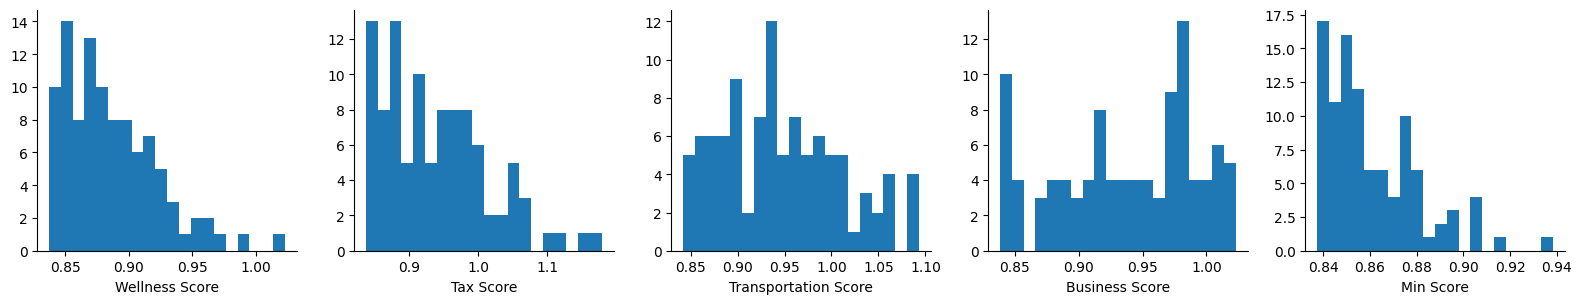

<Figure size 640x480 with 0 Axes>

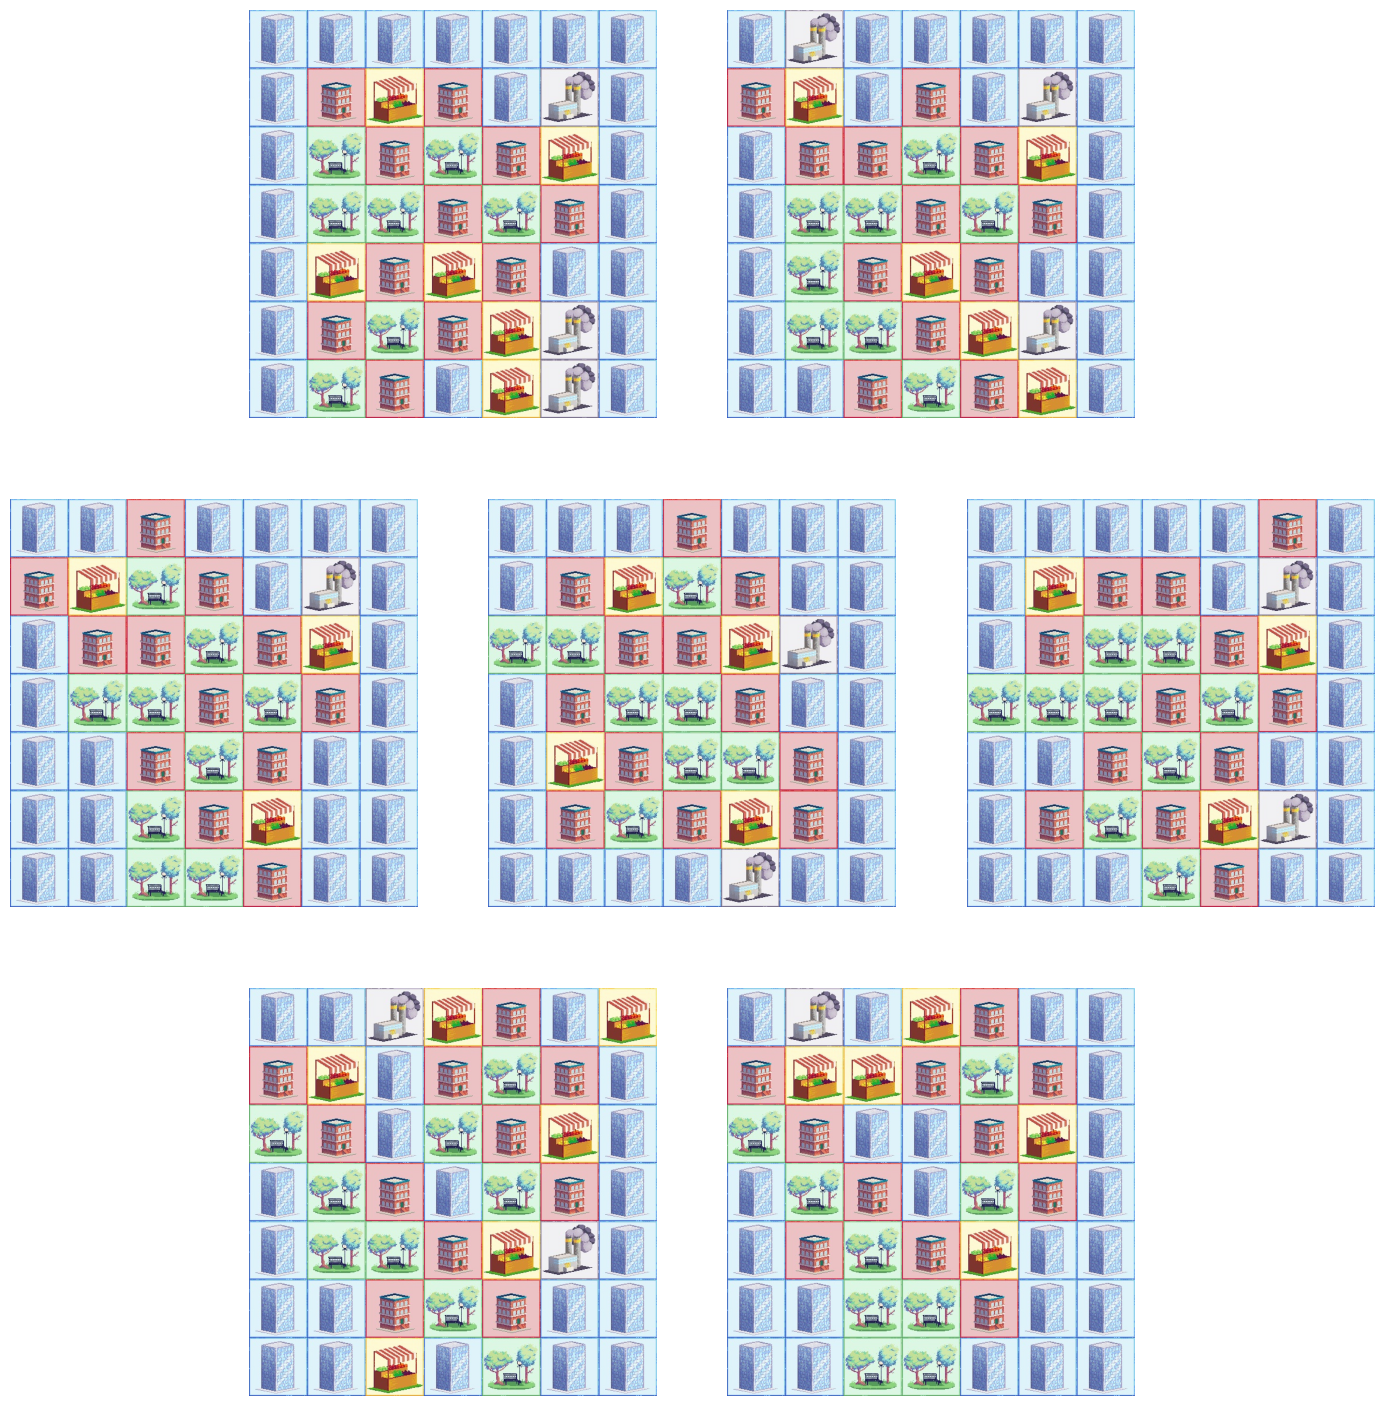

In [ ]:
# TODO pick new grids if these are invalid, find a better way to pick grids
all_predictions_array = np.load("all_predictions.npy")
min_predictions = np.min(all_predictions_array, axis=1) #minimum advisor score (as predicted)
valid_grids = np.sum(min_predictions>0.75) #number of valid grids (as predicted)
valid_indices = np.where(min_predictions > 0.75)[0] # Find indices of grids with min_predictions > 0.75 (valid grids)
# top_100_indices = np.argpartition(min_predictions, -100)[-100:] #indices of top 100 designs (as sorted by minimum advisor score)
# top_100_grids = grids[top_100_indices] #get the top 100 grids

# Get advisor X scores for valid grids (since this is the worst model, need max scores to have best chance of truly valid grids)
advisorX_scores = all_predictions_array[valid_indices, 2]
# Find indices of top 100 advisor 2 scores among valid grids
top_100_indices = valid_indices[np.argpartition(advisorX_scores, -100)[-100:]]
top_100_grids = grids[top_100_indices] # Get the corresponding grids


print(f"Number of valid grids (as predicted): {valid_grids}")
if valid_grids >= 100:
    score = diversity_score(top_100_grids)
    print(f"Current diversity score: {score:.4f}")

    best_submission = np.load("submission.npy")
    loaded_score = diversity_score(best_submission)
    if score > loaded_score:
        final_submission = grids[top_100_indices].astype(int)
        id = np.random.randint(1e8, 1e9-1)
        np.save(f"{id}.npy", final_submission) # uncomment this for real submission
        np.save(f"submission.npy", final_submission) 
        print(f"Score improved! Previous best: {loaded_score:.4f}")
        print("Submission saved")
    elif score <= loaded_score:
        print(f"No improvement. Previous best: {loaded_score:.4f}")
else:
    print("Not enough valid grids found")

plot_ratings_histogram(all_predictions_array[top_100_indices], withmin=True) #plot histograms of top 100 designs
plot_n_grids(top_100_grids[-7:])